<a href="https://colab.research.google.com/github/AlexandreLarget/tensorflow_certification_training/blob/main/04_transfer_learning_in_tensorflow_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TF part1 : Feature Extraction

In [ ]:
!nvidia-smi

Sat Jul  2 08:08:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 classes from Food01)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2022-07-02 08:08:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  59.7MB/s    in 2.7s    

2022-07-02 08:08:10 (59.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder ?
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

## Creating data loaders (preparing the data)

We'll use 'ImagaDataGenerator'

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                            target_size=IMAGE_SHAPE,
                                                            batch_size=BATCH_SIZE,
                                                            class_mode="categorical")

print("Test iamges: ")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Test iamges: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiements with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback


In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log file to: {log_dir}.")
  return tensorboard_callback

## Creating models using TensorFlow Hub

We can access pretrained models on https://tfhub.dev/


In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 

In [ ]:
# Let's create a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequntial model with it.

  Args:
    model_url (str) : A Tensorflow Hub feature extraction URL.
    num_classes (int) : Number of outpout neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_label",
                                           input_shape=IMAGE_SHAPE + (3,))
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Create Resnet model

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_label (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our modele
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Let's fit our Resnet model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log file to: tensorflow_hub/resnet50V2/20220702-080826.
Epoch 1/5
24/24 [==============================] - 35s 771ms/step - loss: 2.0906 - accuracy: 0.3253 - val_loss: 1.2259 - val_accuracy: 0.6100
Epoch 2/5
24/24 [==============================] - 16s 694ms/step - loss: 0.9842 - accuracy: 0.7107 - val_loss: 0.8578 - val_accuracy: 0.7276
Epoch 3/5
24/24 [==============================] - 17s 723ms/step - loss: 0.6732 - accuracy: 0.8027 - val_loss: 0.7458 - val_accuracy: 0.7604
Epoch 4/5
24/24 [==============================] - 16s 686ms/step - loss: 0.5133 - accuracy: 0.8680 - val_loss: 0.6943 - val_accuracy: 0.7748
Epoch 5/5
24/24 [==============================] - 18s 755ms/step - loss: 0.4093 - accuracy: 0.9053 - val_loss: 0.6809 - val_accuracy: 0.7780


In [ ]:
# Let's create a function to plot lost curves
import matplotlib.pyplot as plt

# plot the validation and training curves
def plot_and_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow Histpry object.
  
  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy\
  plt.figure()
  plt.plot(epochs, accuracy, label='trainig_accuracy')
  plt.plot(epochs, val_accuracy, label="val_accurcay")
  plt.title("Accuracy")
  plt.legend();



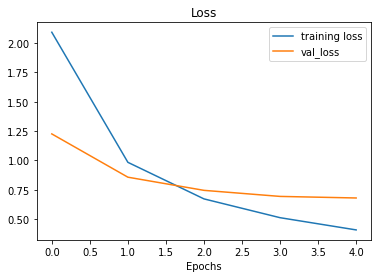

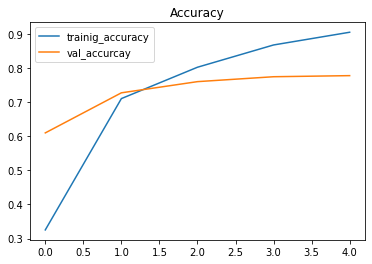

In [ ]:
plot_and_curves(resnet_history)

### Create EfficientNet B0 model

In [ ]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [ ]:
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                    experiment_name="efficientnetb0"))

Saving TensorBoard log file to: tensorflow_hub/efficientnetb0/20220702-081023.
Epoch 1/5
24/24 [==============================] - 26s 740ms/step - loss: 1.8057 - accuracy: 0.4453 - val_loss: 1.2673 - val_accuracy: 0.7400
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 1.0375 - accuracy: 0.7867 - val_loss: 0.8454 - val_accuracy: 0.8336
Epoch 3/5
24/24 [==============================] - 15s 656ms/step - loss: 0.7397 - accuracy: 0.8453 - val_loss: 0.6824 - val_accuracy: 0.8524
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.5957 - accuracy: 0.8800 - val_loss: 0.5964 - val_accuracy: 0.8620
Epoch 5/5
24/24 [==============================] - 16s 670ms/step - loss: 0.5038 - accuracy: 0.9013 - val_loss: 0.5472 - val_accuracy: 0.8680


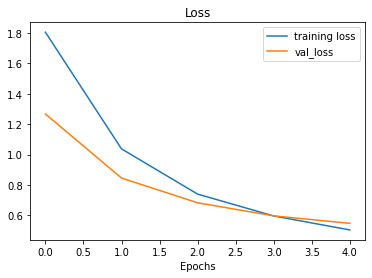

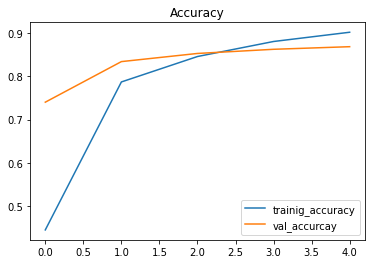

In [ ]:
plot_and_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_label (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes whatsoever.
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model and adjsut the output layer for your own problem (e.g. 1000 classes -> 10 classes of food).
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new ouptput layers).

## Comparing our models results using TensorBoard

When you upload things to TensorBoard.dev, you experiments are public.

In [1]:
# Upload tensorboard dev records
#!tensorboard dev upload --logdir ./tensorflow_hub/ \
#  --name "EfficientnetB0 vs. ResNet50V2" \
#  --description "Comparing two different TF hub feature extraction" \
#  --one_shot

In [2]:
#!tensorboard dev list